### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import plotly.express as px

import copy
import seaborn as sns
import os
from scipy import stats
import datetime

import sqlite3 as sqlite
from sqlalchemy import create_engine
%matplotlib inline

In [2]:
data_path = '/mnt/d/lighthouse/Midterm_data/'

In [3]:
# 10770229 rows × 28 columns
flights = pd.read_csv(data_path + 'flights_cleaned.csv', header = 0)
flights_outlier = pd.read_csv(data_path + 'flights_outliers_no_encode.csv', header = 0)
flights.drop('Unnamed: 0', axis =1, inplace = True)
flights_outlier.drop('Unnamed: 0', axis =1, inplace = True)

In [4]:
flight_taxi = copy.deepcopy(flights[['taxi_out','taxi_in','dep_time','arr_time', 'year', 'month', 'date','origin','dest','dest_state','origin_state']])

In [5]:
flight_taxi.columns = ['taxi_out','taxi_in','dep_time','arr_time', 'year', 'month', 'day','origin','dest','dest_state','origin_state']
flight_taxi['Date']=pd.to_datetime(flight_taxi[['year','month','day']])
flight_taxi

,taxi_out,taxi_in,dep_time,arr_time,year,month,day,origin,dest,dest_state,origin_state,Date
0,7.0,6.0,1753.0,1838.0,2019,3,25,MCI,PHX,AZ,MO,2019-03-25
1,6.0,6.0,1955.0,2036.0,2019,3,25,MCI,PHX,AZ,MO,2019-03-25
2,7.0,8.0,541.0,625.0,2019,3,25,MCI,PHX,AZ,MO,2019-03-25
3,7.0,2.0,1315.0,1432.0,2019,3,25,MCI,SAN,CA,MO,2019-03-25
4,6.0,2.0,1952.0,2106.0,2019,3,25,MCI,SAN,CA,MO,2019-03-25
...,...,...,...,...,...,...,...,...,...,...,...,...
10770224,11.0,3.0,1026.0,1143.0,2019,3,25,MCI,MSP,MN,MO,2019-03-25
10770225,5.0,2.0,2111.0,2242.0,2019,3,25,MCI,MSY,LA,MO,2019-03-25
10770226,7.0,3.0,915.0,1052.0,2019,3,25,MCI,PDX,OR,MO,2019-03-25
10770227,9.0,6.0,1123.0,1204.0,2019,3,25,MCI,PHX,AZ,MO,2019-03-25


# Taxi_in time (arrivals)

In [6]:
flight_taxi_in = copy.deepcopy(flight_taxi[['taxi_in','arr_time','year','month','day','dest','Date']])
flight_taxi_out = copy.deepcopy(flight_taxi[['taxi_out','dep_time','year','month','day','origin','Date']])

,taxi_in,arr_time,year,month,day,dest,Date
0,6.0,1838.0,2019,3,25,PHX,2019-03-25
1,6.0,2036.0,2019,3,25,PHX,2019-03-25
2,8.0,625.0,2019,3,25,PHX,2019-03-25
3,2.0,1432.0,2019,3,25,SAN,2019-03-25
4,2.0,2106.0,2019,3,25,SAN,2019-03-25
...,...,...,...,...,...,...,...
10770224,3.0,1143.0,2019,3,25,MSP,2019-03-25
10770225,2.0,2242.0,2019,3,25,MSY,2019-03-25
10770226,3.0,1052.0,2019,3,25,PDX,2019-03-25
10770227,6.0,1204.0,2019,3,25,PHX,2019-03-25


In [7]:
flight_taxi_in['arr_hour'] = (((flight_taxi_in['arr_time'].astype(int)).astype(str)).str.rjust(4,'0')).str[:2]
flight_taxi_in

,taxi_in,arr_time,year,month,day,dest,Date,arr_hour
0,6.0,1838.0,2019,3,25,PHX,2019-03-25,18
1,6.0,2036.0,2019,3,25,PHX,2019-03-25,20
2,8.0,625.0,2019,3,25,PHX,2019-03-25,06
3,2.0,1432.0,2019,3,25,SAN,2019-03-25,14
4,2.0,2106.0,2019,3,25,SAN,2019-03-25,21
...,...,...,...,...,...,...,...,...
10770224,3.0,1143.0,2019,3,25,MSP,2019-03-25,11
10770225,2.0,2242.0,2019,3,25,MSY,2019-03-25,22
10770226,3.0,1052.0,2019,3,25,PDX,2019-03-25,10
10770227,6.0,1204.0,2019,3,25,PHX,2019-03-25,12


In [9]:
taxi_in_table = flight_taxi_in.groupby("arr_hour")['taxi_in'].describe().sort_values(by='mean', ascending = False)
taxi_in_table.reset_index(inplace = True)
taxi_in_table

,arr_hour,count,mean,std,min,25%,50%,75%,max
0,06,213572.0,7.018930,3.069917,0.0,5.0,6.0,9.0,16.0
1,08,622313.0,6.983028,3.391003,0.0,4.0,6.0,9.0,16.0
2,07,486231.0,6.883239,3.292643,0.0,4.0,6.0,9.0,16.0
3,19,565138.0,6.840973,3.427805,0.0,4.0,6.0,9.0,16.0
4,20,533411.0,6.589060,3.341447,0.0,4.0,6.0,8.0,16.0
5,09,684407.0,6.561014,3.353015,0.0,4.0,6.0,8.0,16.0
6,18,624992.0,6.530946,3.289051,0.0,4.0,6.0,8.0,16.0
7,17,619583.0,6.501731,3.347390,0.0,4.0,6.0,8.0,16.0
8,14,680622.0,6.499091,3.174463,0.0,4.0,6.0,8.0,16.0
9,05,46761.0,6.492184,2.619363,1.0,5.0,6.0,8.0,16.0


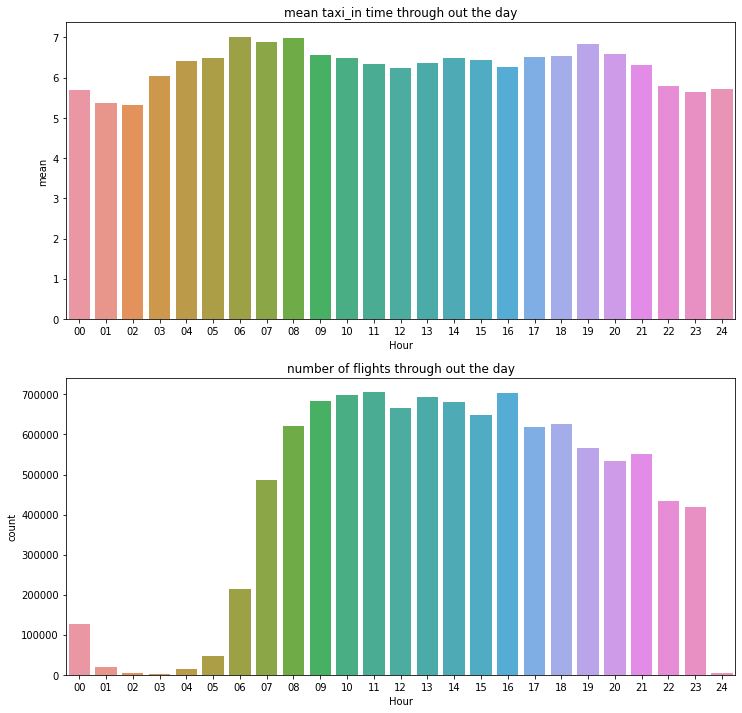

In [17]:
fig, ax = plt.subplots(2,figsize=(12,12))
sns.barplot(x="arr_hour", y="mean", data=taxi_in_table, ax= ax[0])
sns.barplot(x="arr_hour", y="count", data=taxi_in_table, ax= ax[1])
ax[0].set_title('mean taxi_in time through out the day')
ax[1].set_title('number of flights through out the day')
ax[0].set_xlabel('Hour')
ax[1].set_xlabel('Hour')
plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_4_taxi_in.png')

# Taxi_out time (departures)

In [15]:
flight_taxi_out['dep_hour'] = (((flight_taxi_out['dep_time'].astype(int)).astype(str)).str.rjust(4,'0')).str[:2]
flight_taxi_out

,taxi_out,dep_time,year,month,day,origin,Date,dep_hour
0,7.0,1753.0,2019,3,25,MCI,2019-03-25,17
1,6.0,1955.0,2019,3,25,MCI,2019-03-25,19
2,7.0,541.0,2019,3,25,MCI,2019-03-25,05
3,7.0,1315.0,2019,3,25,MCI,2019-03-25,13
4,6.0,1952.0,2019,3,25,MCI,2019-03-25,19
...,...,...,...,...,...,...,...,...
10770224,11.0,1026.0,2019,3,25,MCI,2019-03-25,10
10770225,5.0,2111.0,2019,3,25,MCI,2019-03-25,21
10770226,7.0,915.0,2019,3,25,MCI,2019-03-25,09
10770227,9.0,1123.0,2019,3,25,MCI,2019-03-25,11


In [16]:
taxi_out_table = flight_taxi_out.groupby("dep_hour")['taxi_out'].describe().sort_values(by='mean', ascending = False)
taxi_out_table.reset_index(inplace = True)
taxi_out_table

,dep_hour,count,mean,std,min,25%,50%,75%,max
0,08,694608.0,16.673489,6.331102,0.0,12.0,15.0,21.0,33.0
1,09,663423.0,16.059228,6.177779,0.0,11.0,15.0,20.0,33.0
2,20,475861.0,15.936311,5.978264,1.0,11.0,15.0,20.0,33.0
3,07,686087.0,15.914477,5.927367,0.0,11.0,15.0,19.0,33.0
4,18,549357.0,15.573398,6.257232,0.0,11.0,14.0,19.0,33.0
5,22,248866.0,15.542481,5.569331,1.0,11.0,15.0,19.0,33.0
6,10,682841.0,15.507092,5.997218,0.0,11.0,14.0,19.0,33.0
7,21,301441.0,15.505933,6.007948,1.0,11.0,14.0,19.0,33.0
8,24,297.0,15.434343,4.961667,6.0,12.0,14.0,18.0,33.0
9,11,705462.0,15.403659,5.841871,0.0,11.0,14.0,19.0,33.0


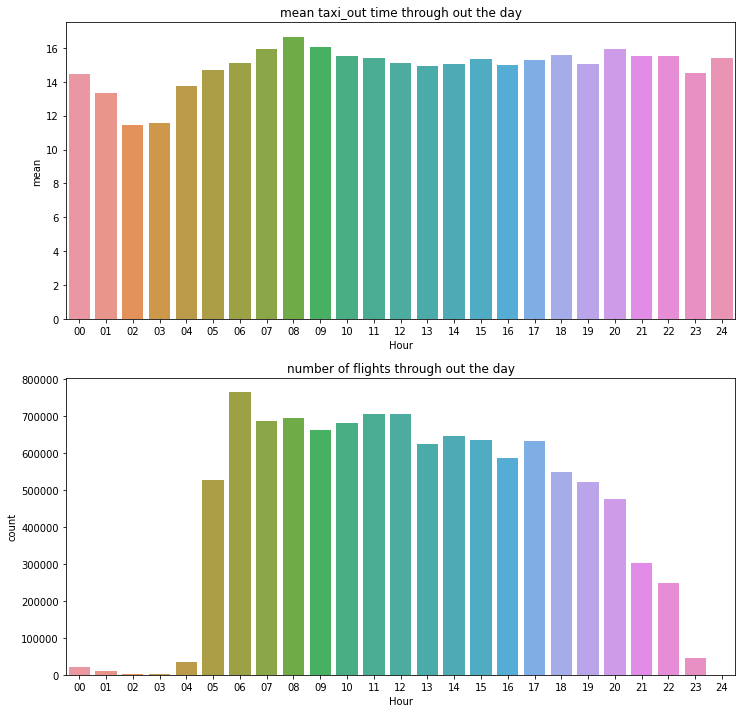

In [18]:
fig, ax = plt.subplots(2,figsize=(12,12))
sns.barplot(x="dep_hour", y="mean", data=taxi_out_table, ax= ax[0])
sns.barplot(x="dep_hour", y="count", data=taxi_out_table, ax= ax[1])
ax[0].set_title('mean taxi_out time through out the day')
ax[1].set_title('number of flights through out the day')
ax[0].set_xlabel('Hour')
ax[1].set_xlabel('Hour')
plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_4_taxi_out.png')

### Comparing between years

In [89]:
flight_taxi_out_2018 = copy.deepcopy(flight_taxi_out[flight_taxi_out['year']==2018])
flight_taxi_out_2019 = copy.deepcopy(flight_taxi_out[flight_taxi_out['year']==2019])

flight_taxi_in_2018 = copy.deepcopy(flight_taxi_in[flight_taxi_in['year']==2018])
flight_taxi_in_2019 = copy.deepcopy(flight_taxi_in[flight_taxi_in['year']==2019])

In [90]:
taxi_out_table_2018 = flight_taxi_out_2018.groupby("dep_hour")['taxi_out'].describe().sort_values(by='mean', ascending = False)
taxi_out_table_2018.reset_index(inplace = True)

taxi_out_table_2019 = flight_taxi_out_2019.groupby("dep_hour")['taxi_out'].describe().sort_values(by='mean', ascending = False)
taxi_out_table_2019.reset_index(inplace = True)

taxi_in_table_2018 = flight_taxi_in_2018.groupby("arr_hour")['taxi_in'].describe().sort_values(by='mean', ascending = False)
taxi_in_table_2018.reset_index(inplace = True)

taxi_in_table_2019 = flight_taxi_in_2019.groupby("arr_hour")['taxi_in'].describe().sort_values(by='mean', ascending = False)
taxi_in_table_2019.reset_index(inplace = True)

In [92]:
taxi_out_table_2018

,dep_hour,count,mean,std,min,25%,50%,75%,max
0,08,345081.0,16.608182,6.288251,0.0,12.0,15.0,21.0,33.0
1,24,141.0,16.184397,5.527338,6.0,12.0,15.0,19.0,31.0
2,09,327154.0,16.044640,6.200983,0.0,11.0,15.0,20.0,33.0
3,20,233224.0,15.879498,5.978372,1.0,11.0,15.0,20.0,33.0
4,07,338663.0,15.840585,5.915552,1.0,11.0,15.0,19.0,33.0
5,18,269566.0,15.591926,6.275109,0.0,11.0,14.0,19.0,33.0
6,21,146709.0,15.559495,6.009484,1.0,11.0,15.0,19.0,33.0
7,10,337880.0,15.506582,5.977124,0.0,11.0,14.0,19.0,33.0
8,22,121404.0,15.502974,5.602159,1.0,11.0,15.0,19.0,33.0
9,11,350020.0,15.477424,5.880234,0.0,11.0,14.0,19.0,33.0


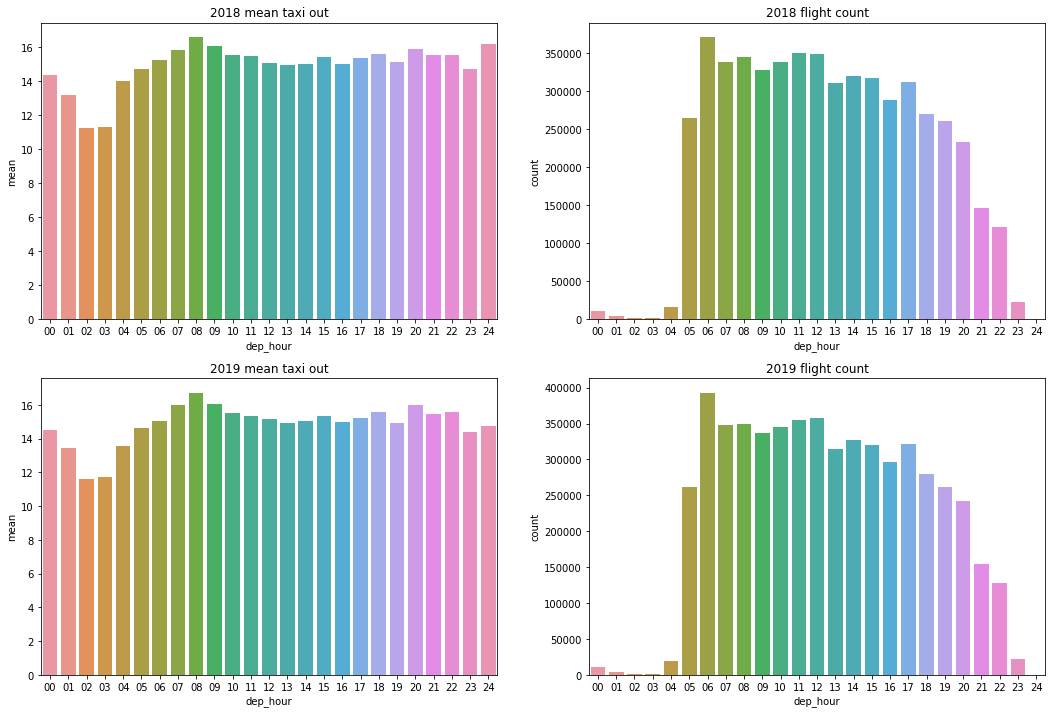

In [96]:
fig, ax = plt.subplots(2,2,figsize=(18,12))
sns.barplot(x="dep_hour", y="mean", data=taxi_out_table_2018, ax= ax[0][0])
sns.barplot(x="dep_hour", y="count", data=taxi_out_table_2018, ax= ax[0][1])
sns.barplot(x="dep_hour", y="mean", data=taxi_out_table_2019, ax= ax[1][0])
sns.barplot(x="dep_hour", y="count", data=taxi_out_table_2019, ax= ax[1][1])
ax[0][0].set_title('2018 mean taxi out')
ax[0][1].set_title('2018 flight count')
ax[1][0].set_title('2019 mean taxi out')
ax[1][1].set_title('2019 flight count')
plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_4_taxi_out_year_comparison.png')

In [97]:
taxi_in_table_2018

,arr_hour,count,mean,std,min,25%,50%,75%,max
0,08,306729.0,6.918563,3.373070,0.0,4.0,6.0,9.0,16.0
1,06,106961.0,6.900478,3.048397,0.0,5.0,6.0,9.0,16.0
2,07,238886.0,6.815699,3.284221,0.0,4.0,6.0,9.0,16.0
3,19,273737.0,6.800261,3.443506,0.0,4.0,6.0,9.0,16.0
4,20,268319.0,6.553449,3.342830,0.0,4.0,6.0,8.0,16.0
5,18,312110.0,6.528182,3.296749,0.0,4.0,6.0,8.0,16.0
6,09,340735.0,6.505419,3.336688,0.0,4.0,6.0,8.0,16.0
7,10,346917.0,6.497661,3.285918,0.0,4.0,6.0,8.0,16.0
8,17,306198.0,6.483047,3.360836,0.0,4.0,6.0,8.0,16.0
9,14,335499.0,6.467843,3.186330,0.0,4.0,6.0,8.0,16.0


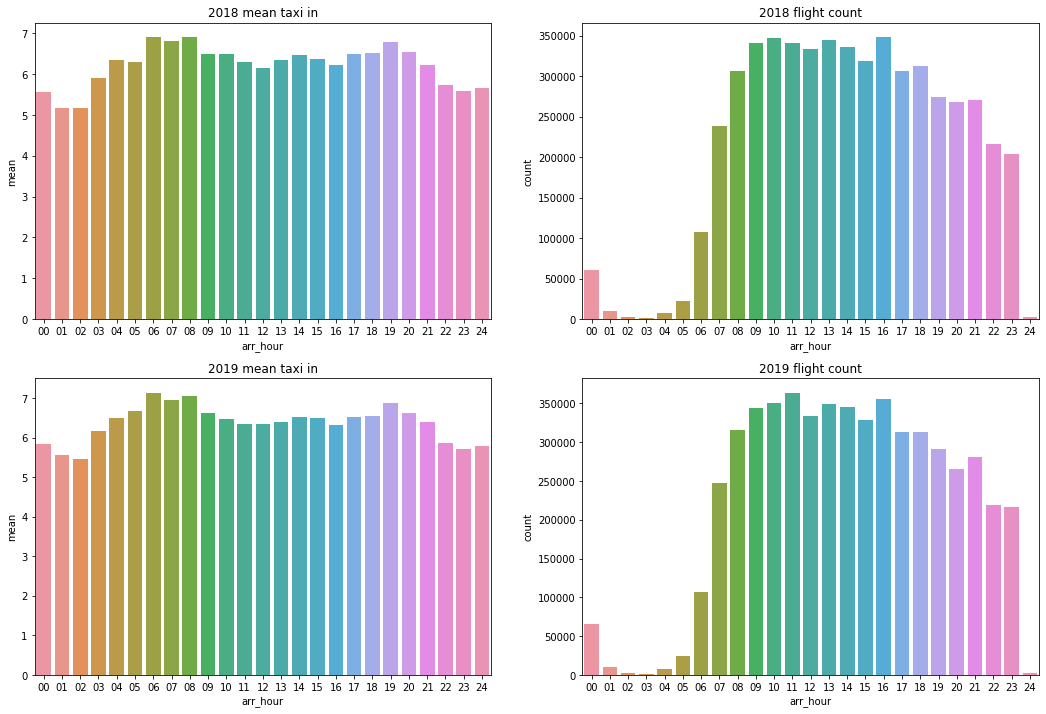

In [99]:
fig, ax = plt.subplots(2,2,figsize=(18,12))
sns.barplot(x="arr_hour", y="mean", data=taxi_in_table_2018, ax= ax[0][0])
sns.barplot(x="arr_hour", y="count", data=taxi_in_table_2018, ax= ax[0][1])
sns.barplot(x="arr_hour", y="mean", data=taxi_in_table_2019, ax= ax[1][0])
sns.barplot(x="arr_hour", y="count", data=taxi_in_table_2019, ax= ax[1][1])
ax[0][0].set_title('2018 mean taxi in')
ax[0][1].set_title('2018 flight count')
ax[1][0].set_title('2019 mean taxi in')
ax[1][1].set_title('2019 flight count')
plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_4_taxi_in_year_comparison.png')

## airport specific(random airport, ~360 is too many)

In [52]:
airports = list(flight_taxi_out['origin'].unique())
random_airports = random.sample(airports, 5)
random_airports

['FSD', 'FNT', 'MKE', 'PVD', 'ADK']

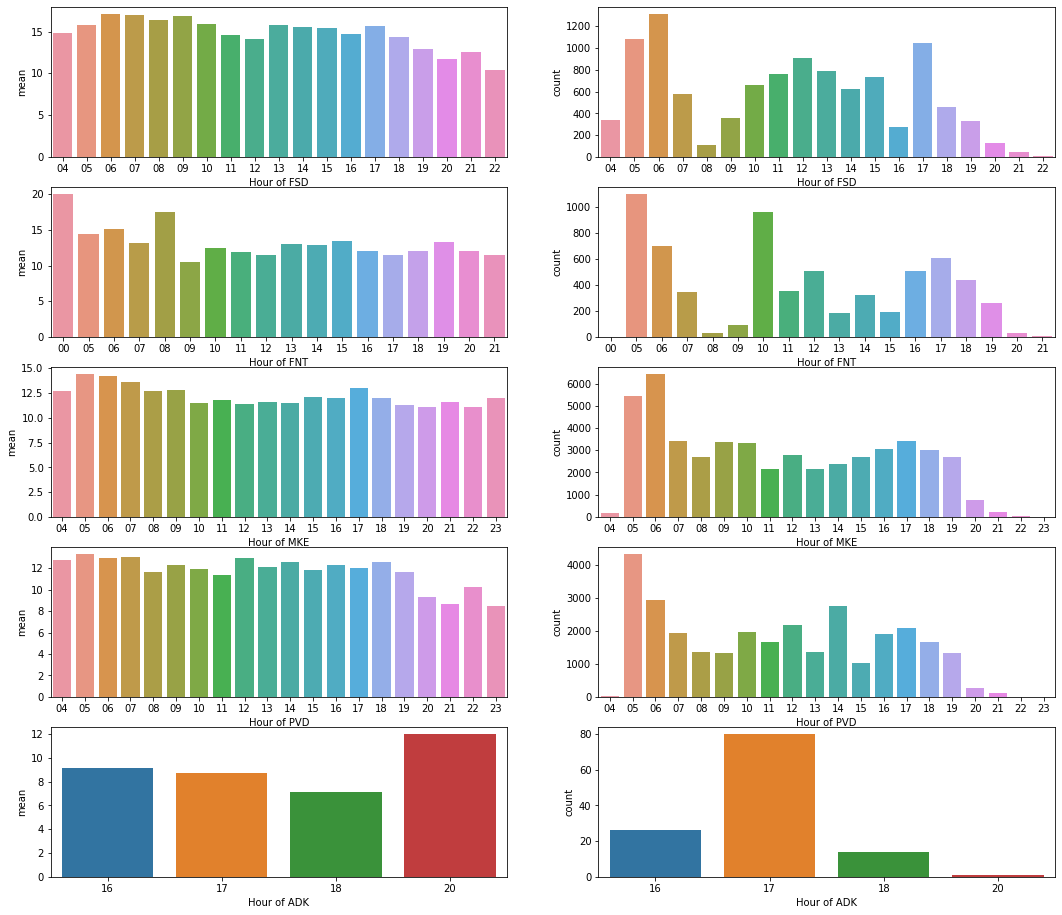

In [54]:
fig, ax = plt.subplots(5,2,figsize=(18,16))
for i in range(len(random_airports)):
    temp = copy.deepcopy(flight_taxi_out[flight_taxi_out['origin']==random_airports[i]])
    temp_out_table = temp.groupby("dep_hour")['taxi_out'].describe().sort_values(by='mean', ascending = False)
    temp_out_table.reset_index(inplace = True)
    sns.barplot(x="dep_hour", y="mean", data=temp_out_table, ax= ax[i][0])
    sns.barplot(x="dep_hour", y="count", data=temp_out_table, ax= ax[i][1])
    ax[i][0].set_xlabel(f'Hour of {random_airports[i]}')
    ax[i][1].set_xlabel(f'Hour of {random_airports[i]}')
#plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_4_random_airport.png')

## Looking at specific time and airport

In [69]:
test_out = copy.deepcopy(flight_taxi_out[flight_taxi_out['origin']=='PVD'])
test_in = copy.deepcopy(flight_taxi_in[flight_taxi_in['dest']=='PVD'])

test_date_out = copy.deepcopy(test_out[(test_out['year']==2019) & (test_out['month']==4) & (test_out['day']==24)])
test_date_in = copy.deepcopy(test_in[(test_in['year']==2019) & (test_in['month']==4) & (test_in['day']==24)])

test_in

,taxi_in,arr_time,year,month,day,dest,Date,arr_hour
92,3.0,1057.0,2019,3,25,PVD,2019-03-25,10
93,4.0,111.0,2019,3,25,PVD,2019-03-25,01
94,6.0,2239.0,2019,3,25,PVD,2019-03-25,22
95,4.0,1706.0,2019,3,25,PVD,2019-03-25,17
254,4.0,121.0,2019,3,25,PVD,2019-03-25,01
...,...,...,...,...,...,...,...,...
10769068,5.0,2022.0,2019,3,25,PVD,2019-03-25,20
10769069,4.0,2354.0,2019,3,25,PVD,2019-03-25,23
10769373,3.0,1310.0,2019,3,25,PVD,2019-03-25,13
10769638,6.0,2119.0,2019,3,25,PVD,2019-03-25,21


### Monthly mean of PVD airport

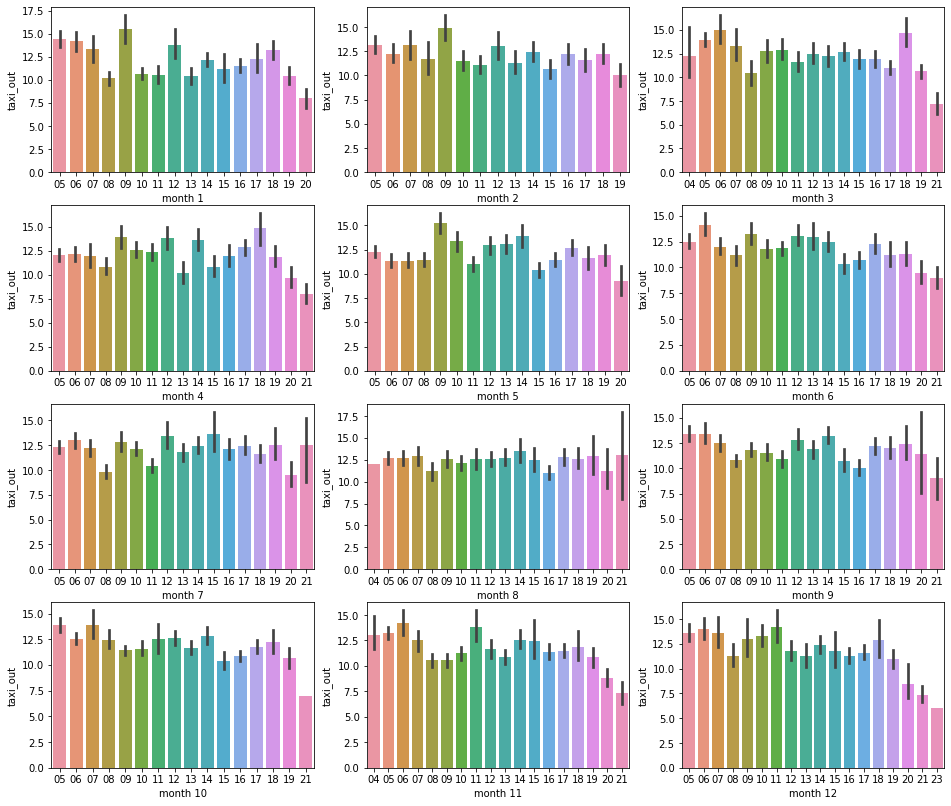

In [70]:
fig, ax = plt.subplots(4,3,figsize=(16,14))
row = 0
col = 0
for i in range(1,13):
    if col == 3:
        row += 1
        col = 0
    test_cur = copy.deepcopy(test_out[(test_out['year']==2019)&(test_out['month']==i)])
    sns.barplot(x="dep_hour", y="taxi_out", data=test_cur, ax = ax[row][col])
    ax[row][col].set(xlabel= f'month {i}')
    col += 1
plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_4_monthly_taxi_out_PVD.png')

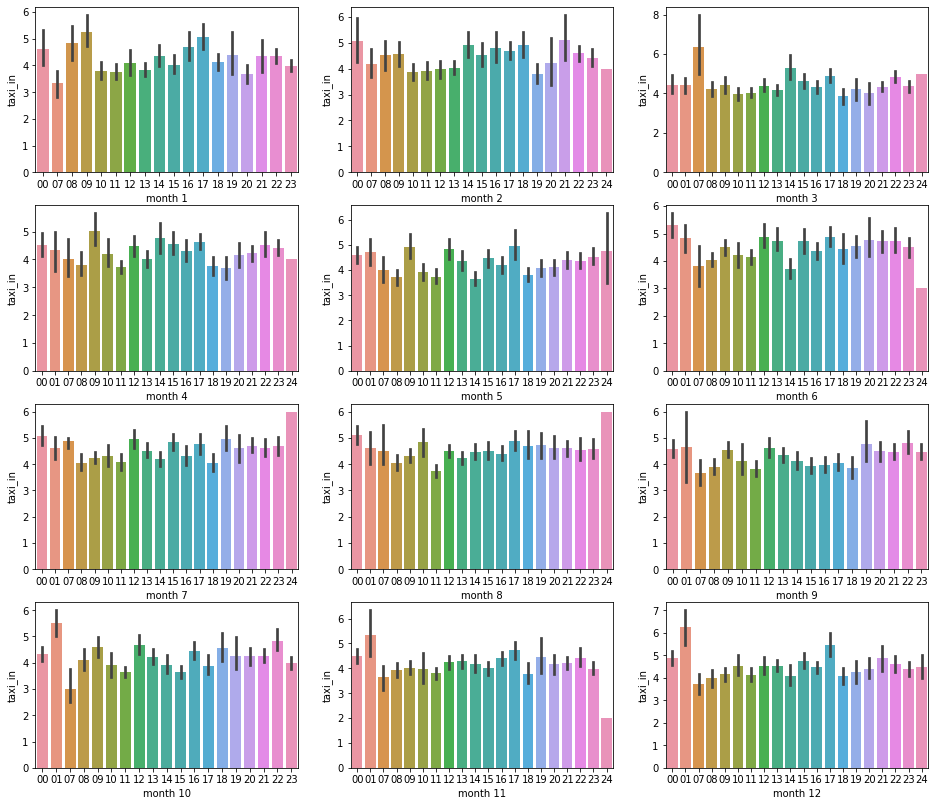

In [72]:
fig, ax = plt.subplots(4,3,figsize=(16,14))
row = 0
col = 0
for i in range(1,13):
    if col == 3:
        row += 1
        col = 0
    test_cur = copy.deepcopy(test_in[(test_in['year']==2019)&(test_in['month']==i)])
    sns.barplot(x="arr_hour", y="taxi_in", data=test_cur, ax = ax[row][col])
    ax[row][col].set(xlabel= f'month {i}')
    col += 1
plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_4_monthly_taxi_in_PVD.png')

### Looking at just one day per month

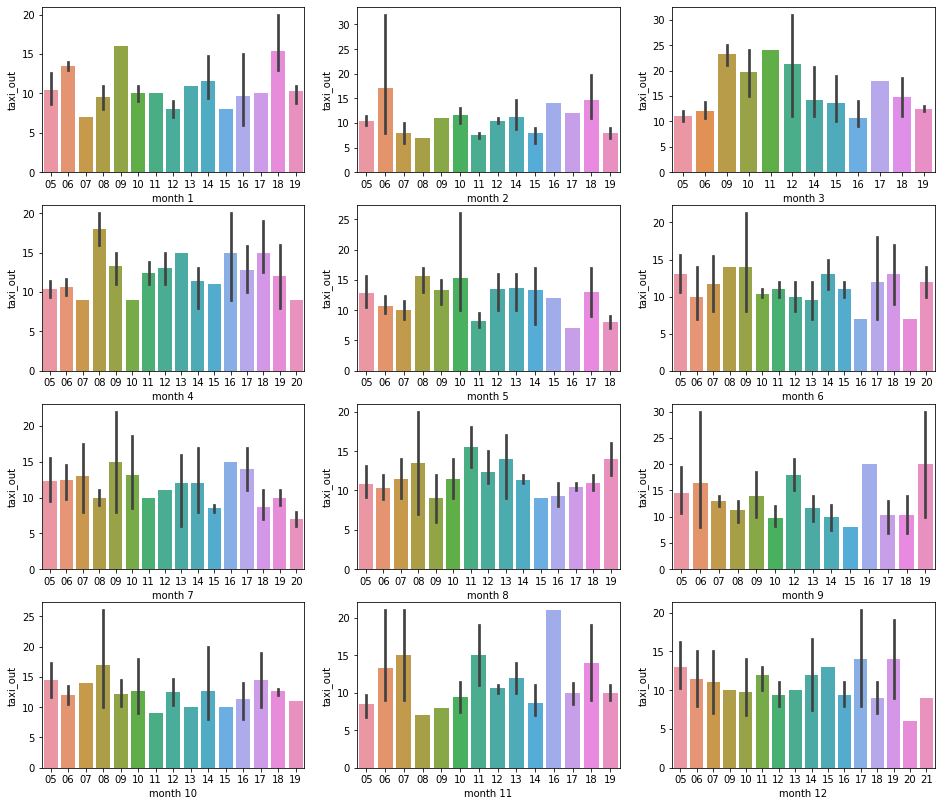

In [80]:
fig, ax = plt.subplots(4,3,figsize=(16,14))
row = 0
col = 0
for i in range(1,13):
    if col == 3:
        row += 1
        col = 0
    test_cur = copy.deepcopy(test_out[(test_out['year']==2019)&(test_out['month']==i)&(test_out['day']==10)])
    sns.barplot(x="dep_hour", y="taxi_out", data=test_cur, ax = ax[row][col])
    ax[row][col].set(xlabel= f'month {i}')
    col += 1
plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_4_taxi_out_2019-month-10_PVD.png')